# EDA for Data Processing and Augmentations Script
Generates a processed training dataset from which we can train our algorithm

Includes:
  * cropping and resizing the data
  * Applying a gridmask
  * Shift Scale and Rotate
  * Change either Brightness or contrast
  * Add Gaussian Blur or noise
  * Finally, we oversample to handle the class imbalances 
  
All of these (except crop and resize) occur with probability (p < 1). 

Results are exported to a new parquet file to be used for training. But augmentations are written in functions so that they can be changed on the fly for different models. 

In [215]:
import gc
import os
import random
import sys
import albumentations as A
import pyarrow
import cv2

from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

In [216]:
# Paths
datadir = "../data"
inputdir= datadir + "/raw"
outputdir= datadir + "/processed"
inputdir

'../data/raw'

In [217]:
# Parameters
HEIGHT = 137
WIDTH = 236
SIZE = 128

## Load images

In [218]:
# during submission, we have to revert back to normal parquet but for now we can use feather
def prepare_image(datadir, data_type, submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir + f'/{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(datadir + f'/{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    
    #somehow the original input is inverted
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [219]:
%%time

# Load our data
train = pd.read_csv(datadir+'/train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] 
images = prepare_image(inputdir, data_type='train', submission=False, indices=indices)

image_df_list 1
Wall time: 8.55 s


## Crop and Resize 
Applied to all images so that each has a standard 'base'

In [220]:
# bounding box
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    
    #remove low intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

In [221]:
def crop_char_image(image, threshold=40./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

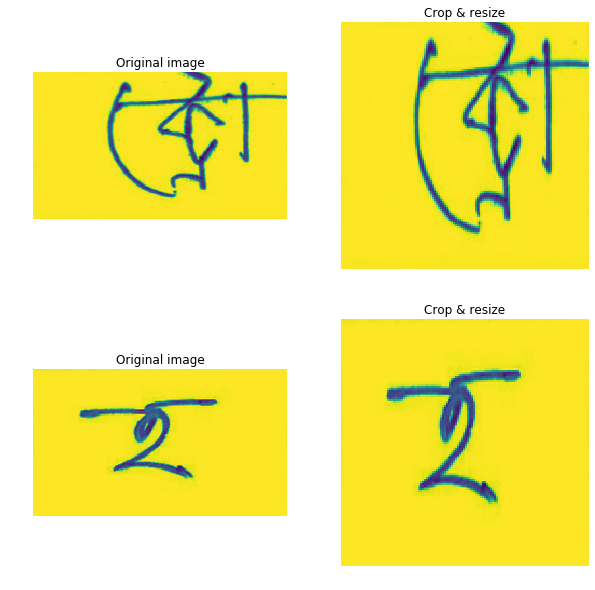

In [222]:
# run for all images 
def runCropRsz(images):
    crop_rsz_img = []
    for idx in range(len(images)):
        #img = cv2.normalize(images[idx], None, dtype=cv2.CV_32F)
        #img0 = (255 - images[idx]).astype(np.float32) 
        #normalize each image by its max val
        #img = (img0*(255.0/img0.max())).astype(np.float32)
        img = images[idx]
        img = crop_char_image(img, threshold = 40/255)
        img = resize(img)
        

        # add to our stored list
        crop_rsz_img.append(img)

    crop_rsz_img = np.array(crop_rsz_img)
    
    return crop_rsz_img

crop_rsz_img = runCropRsz(images[:5])

# confirm that processing worked
n_imgs = 2
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in range(n_imgs):
    img0 = images[idx].astype(np.uint8)
    img = crop_rsz_img[idx]
    
    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')
plt.show()

## Gridmask
With albumentations

In [223]:
import albumentations
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform
from albumentations.augmentations import functional as F

class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

## Generic Data Augmentations
Utilizing albumentations

We must keep in mind that we are working with handwriting, so we are limited to the augmentations that would be considered effective. For example, a letter would never be written sideways or upside down (but, it can rotate slightly) or it will never be flipped. 

In summary, we limit our augmentations to those that may actually be seen in real life

In [410]:
# define our augmentations
def augPipeline(P = .75):
    return A.Compose([
        A.IAAAdditiveGaussianNoise(p=.6),
        A.OneOf([
            A.MedianBlur(blur_limit=3, p=0.6),
            A.Blur(blur_limit=1, p=0.6),
        ], p=0.5),
        A.ShiftScaleRotate( rotate_limit=15, p=.85), # leave shift and scale as defaults
        A.OneOf([
            A.OpticalDistortion(p=.6),
            A.GridDistortion(p=.4),
            A.IAAPiecewiseAffine(p=.75),
        ], p=.5),
        GridMask(num_grid=(2,3), rotate=15, p=.75)],
        p=P)

augmentation = augPipeline()

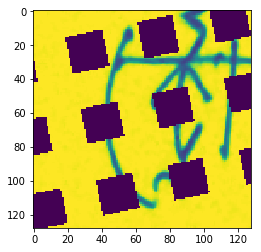

In [411]:
# testing
img = dataset.get_example(0)[0]
aug_img = augmentation(image = img)['image']
plt.imshow(aug_img)

# Dataset Class
Once we have our basic images, we push to a pytorch dataset and prepare for augmentations

In [236]:
import six
import torch
from torch.utils.data import Dataset, DataLoader

# wrapper
class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, np.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example_img = self.transform(image = example[0])['image']
        return example_img, example[1]

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError

In [237]:
# actual class
class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        
        # for future Affine transformation
        x = x.astype(np.float32)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

In [238]:
dataset = BengaliAIDataset(crop_rsz_img, labels = train_labels[:len(crop_rsz_img)], transform = augmentation)  
image, label = dataset[0]
print('image', image.shape, 'label', label)

image (128, 128) label [15  9  5]


30it [00:00, 61.31it/s]


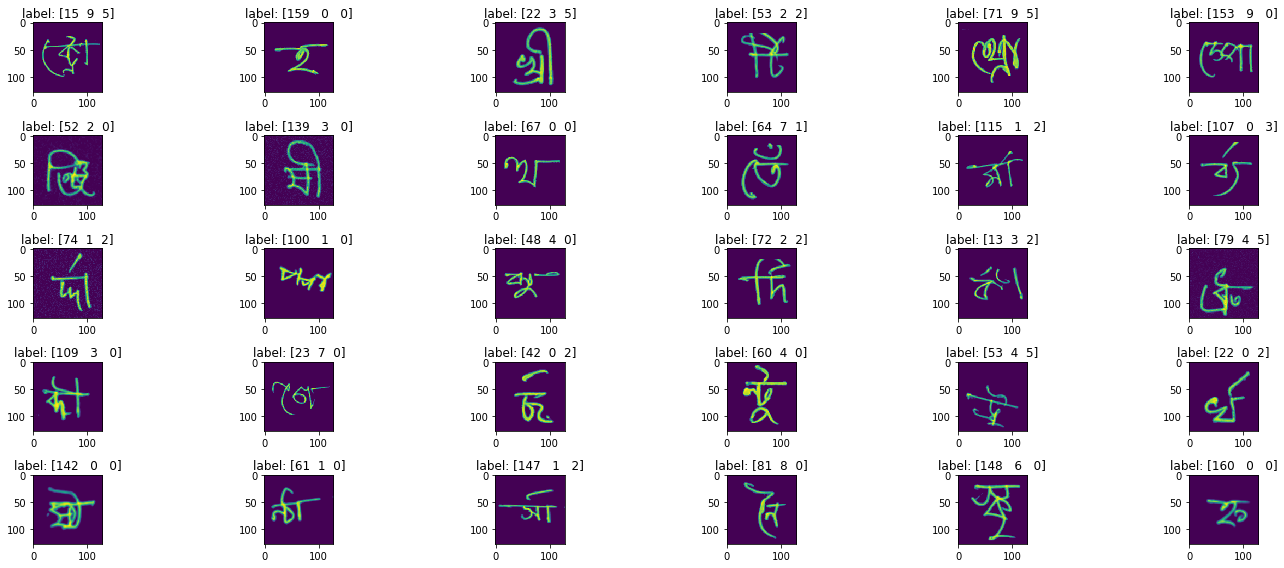

In [389]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = dataset[i]
    ax.imshow(image)
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()


## Balance our Classes
there is an imbalance in our classes. There are two imbalances and therefore, there are two types of balancing that we can do.  We can balance according to the individual graphemes or we can balance according the whole character

Thoughts on how to implement class balancing
  * generate augmented data for the underrepresented labels
  * then use a weighted sampler for whole class


Character (i.e., solving multi-label class imbalance column wise)
  * This is not a solved problem yet (or at least its not one with an easy python implementation)
  * rather than spend a ton of time work on this, lets just select some of the underrepresented samples
  * and duplicate these classes x times with augmentation p = 1
    * the number of times to duplicate will be decided base on how often it appears in the dataset 
    
    
This is not going to work - or be way too much effort for the results
I think the best way is to do a weighted resampler and just increase the data augmentation Prob and number of epochs 

In [401]:
print(train.columns)
train.grapheme.value_counts() # does not appear to be a huge imbalance at least for the entire graphemes

Index(['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic',
       'grapheme'],
      dtype='object')


য়ে        283
দ্দা      178
ঘ         178
র্লি      177
ঝু        177
         ... 
ঠী        129
ষ্ট্যা    128
ঙ্কো      128
ম্নী      126
ক্ষ্ণ     118
Name: grapheme, Length: 1295, dtype: int64

In [402]:
train.grapheme_root.value_counts().tolist() # huge imbalances here

[5736,
 5596,
 5420,
 5321,
 5149,
 4926,
 4395,
 4392,
 4374,
 4015,
 3690,
 3630,
 3461,
 3458,
 3438,
 3354,
 3281,
 2961,
 2936,
 2780,
 2688,
 2402,
 2339,
 2313,
 2313,
 2312,
 2311,
 2188,
 2094,
 2073,
 1957,
 1936,
 1746,
 1723,
 1680,
 1633,
 1585,
 1553,
 1539,
 1537,
 1531,
 1518,
 1418,
 1376,
 1365,
 1363,
 1285,
 1248,
 1207,
 1142,
 1139,
 1127,
 1127,
 1127,
 1116,
 1083,
 1083,
 1067,
 1057,
 1051,
 1039,
 1024,
 978,
 973,
 957,
 957,
 952,
 942,
 940,
 935,
 934,
 928,
 927,
 908,
 886,
 883,
 868,
 813,
 796,
 790,
 787,
 786,
 768,
 761,
 760,
 759,
 757,
 757,
 751,
 738,
 732,
 727,
 637,
 633,
 631,
 627,
 627,
 623,
 622,
 617,
 612,
 609,
 607,
 592,
 580,
 575,
 562,
 481,
 480,
 476,
 475,
 465,
 462,
 460,
 458,
 456,
 452,
 448,
 444,
 443,
 437,
 436,
 426,
 342,
 337,
 336,
 336,
 331,
 326,
 324,
 321,
 318,
 317,
 311,
 308,
 307,
 305,
 305,
 302,
 293,
 292,
 285,
 278,
 276,
 175,
 171,
 168,
 165,
 164,
 160,
 159,
 158,
 157,
 153,
 152,
 151,
 1

In [403]:
train.vowel_diacritic.value_counts()

0     41508
1     36886
7     28723
2     25967
4     18848
3     16152
9     16032
5      5297
6      4336
10     3563
8      3528
Name: vowel_diacritic, dtype: int64

In [404]:
train.consonant_diacritic.value_counts()

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

In [418]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# exploring what happens with oversampling
# the undersampled roots, vowels, and consonants are all apart of different graphemes.  
# so oversampling in one, creates a larger imbalance in the other 
# e.g., oversampling vowels creates a larger imbalance in consonants
# makes this a super annoying problem 

n_total = len(train)
ros = RandomOverSampler(random_state=42)
X = train[['image_id',  'grapheme_root', 'vowel_diacritic','consonant_diacritic']]
y = train.grapheme

X_res, y_res = ros.fit_resample(X, y)
X_res = pd.DataFrame(X_res, columns = ['image_id',  'grapheme_root', 'vowel_diacritic','consonant_diacritic'])
#print('Resampled dataset shape %s' % Counter(y_res))
X_res.vowel_diacritic.value_counts(), X_res.grapheme_root.value_counts(), X_res.consonant_diacritic.value_counts()

(0     75561
 1     67354
 7     52072
 2     47544
 4     34243
 3     29998
 9     29432
 5      9622
 6      7924
 10     6509
 8      6226
 Name: vowel_diacritic, dtype: int64, 72     10471
 64     10188
 13      9622
 107     9622
 23      9622
        ...  
 87       283
 158      283
 45       283
 73       283
 0        283
 Name: grapheme_root, Length: 168, dtype: int64, 0    228664
 2     43016
 5     39054
 4     38488
 1     13584
 6      2547
 3      1132
 Name: consonant_diacritic, dtype: int64)

What we are going to do is regenerate the dataloader after every epoch with a different sample
So, that means we create 4 sets of weights such that we draw an equal sample of every class every 4th epoch

In [479]:
train.columns

Index(['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic',
       'grapheme'],
      dtype='object')

In [511]:
from torch.utils.data.sampler import WeightedRandomSampler
import itertools

def genWeightTensor(column, train):
    class_counts = train[column].value_counts()
    weight = 1 / class_counts
    return torch.tensor([weight[t] for t in train[column]])

consonant_weights = genWeightTensor("consonant_diacritic", train[:len(crop_rsz_img)])
root_weights = genWeightTensor("grapheme_root", train[:len(crop_rsz_img)])
vowel_weights = genWeightTensor("vowel_diacritic", train[:len(crop_rsz_img)])
grapheme_weights = genWeightTensor("grapheme", train[:len(crop_rsz_img)])

weights = {"consonant_diacritic": consonant_weights,
           "grapheme_root": root_weights,
           "vowel_diacritic": vowel_weights,
           "grapheme": grapheme_weights}

keys = list(weights.keys())

for i, key in zip(range(8), itertools.cycle(keys)):
    print(i, key)
    
    # generate sampler and loader specific to epoch
    w = weights[key]
    sampler = WeightedRandomSampler(w, len(w))
    train_loader = DataLoader(dataset, batch_size=64, sampler=sampler)
    
    for j, (x, y) in enumerate(train_loader):
        print("x.shape {}, y.shape {}".format(x.shape, y.shape))
        col = train.columns.get_loc(key) -1 if key != "grapheme" else 2
        class_count =  torch.tensor([(y[:,col] == t).sum() for t in torch.unique(y[:,col], sorted=True)])
        print(class_count)
        if j == 2:
            break

# sweet this looks like it is working exactly as intended

0 consonant_diacritic


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 9, 12,  9,  9,  9,  6, 10])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([11,  4,  7, 12,  9, 11, 10])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 9,  5, 12,  9, 12, 12,  5])
1 grapheme_root


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        2, 2, 1, 1, 1])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 2, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1])
2 vowel_diacritic


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 4, 10,  6,  4,  3,  6,  8,  5,  7,  4,  7])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([13,  8,  7,  4,  3,  3,  4,  6,  6,  4,  6])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([3, 6, 9, 8, 2, 4, 6, 9, 4, 9, 4])
3 grapheme


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([39,  1,  5, 11,  8])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([40,  1, 10,  7,  6])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([42,  8,  5,  9])
4 consonant_diacritic


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([12,  7,  9,  9,  7,  7, 13])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 7,  7,  6, 10,  8, 11, 15])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 8,  9,  9,  8,  9,  7, 14])
5 grapheme_root


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 1, 1])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 2, 1,
        1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 2, 2, 1, 1, 2])
6 vowel_diacritic


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 5, 11,  4,  6,  7,  5,  4,  5,  7,  6,  4])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([9, 5, 5, 6, 4, 9, 5, 3, 5, 7, 6])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([ 6,  4,  4,  6,  8,  3,  7,  9,  5,  2, 10])
7 grapheme


C:\Users\ABell\Anaconda3\lib\site-packages\torch\utils\data\sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([40,  2,  6, 12,  4])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([44,  5,  5, 10])
x.shape torch.Size([64, 128, 128]), y.shape torch.Size([64, 3])
tensor([34,  7, 13, 10])


## Main Function: Gen and Load Dataset
Runs the entire process: imports, crop and resize, generate and return the pytorch dataset 

In [ ]:
# Note that right now it is only set up for loading the training data
def genDataset(data_type = "train", balance_classes = "word"):
    assert data_type in ["train", "test"]
    assert balance_classes in ['character', 'word', None]
    submit_val = True
    
    # Load our data
    if data_type == "train":
        train = pd.read_csv(datadir+'/train.csv')
        train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
        submit_val = False
        
    indices = [0, 1, 2, 3]
    images = prepare_image(inputdir, data_type=data_type, submission=submit_val, indices=indices)
    
    # run our crop and resize functions
    crop_rsz_img = runCropRsz(images)

    # init augmentation pipeline
    augmentation = augPipeline()

    # generate our dataset
    dataset = BengaliAIDataset(crop_rsz_img, labels = train_labels, transform = augmentation)  
    
    return dataset